SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CAL_ARCH= '61130833202621'     / Archon time in 10ns per tick at CAL_SYS        CAL_SYS = '2023-12-06T09:24:01.685090' / system time at CAL_ARCH                CAMD_VER= 'Nov 26 2023 20:21:34' / camerad build date                           COADDS  =                    4 / number of coadds                               FILENAME= 'n0097.fits'         / this fi

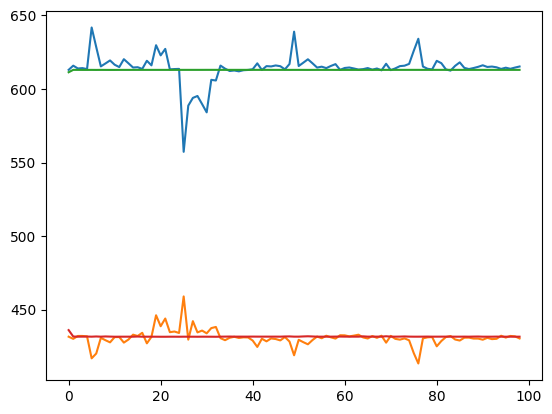

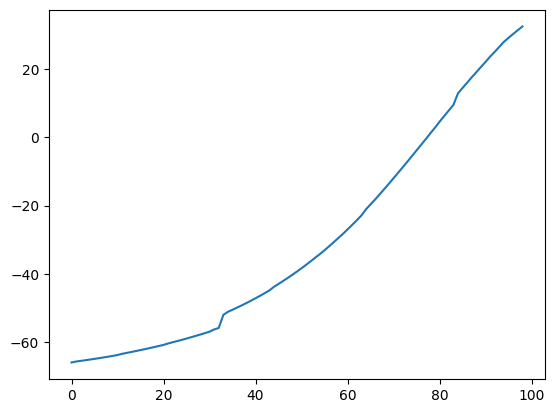

[613.01422974 431.72897203]


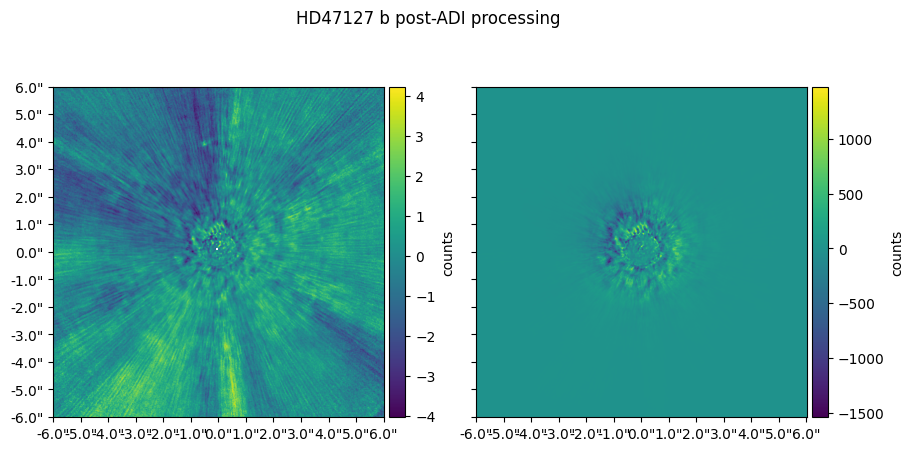

In [2]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
import pyklip
import pyklip.klip as klip
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
import astropy.units as u
from importlib import reload
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
%matplotlib inline

#define functions for display
def add_label(ax,txt,imsz):
    ax.text(5,imsz-10,txt,c='w',size=18)
    
def add_cbar(im,ax,f,lb="counts"):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%',pad=0.05)
    f.colorbar(im,cax=cax,orientation='vertical',label=lb)
    
def set_display(stampsz,stampcen,tickint=1):
    mnx=int(stampcen[0]-stampsz/2)
    mxx=int(stampcen[0]+stampsz/2+1)
    mny=int(stampcen[1]-stampsz/2)
    mxy=int(stampcen[1]+stampsz/2+1)
    ranges=(mnx,mxx,mny,mxy)
    platescale=.009971 ###for GPI its .01414
    nticks=np.floor(stampsz*platescale/2/tickint)
    ticklabels=np.arange(-1*nticks,nticks+1)*tickint
    ticklabels_str=[str(lab)+'\"' for lab in ticklabels]
    ticks = ticklabels/platescale + stampsz/2
    return(ranges,ticks,ticklabels_str)

warnings.filterwarnings("ignore")

#define ADI process
def cADI_NIRC2(flist, write_intermediate=False):
    
    #get data from fits, create raw image arrays
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #np arrays indices are flipped!
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))#ctrs[0]
            #print(ctrs[0]) #plot,, find center from first
            
            #check each centroid post-cross-correlation
            aligned_cube[0,:,:] = rawcube[0,:,:]
            print(head)
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            #print(shifts)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrs[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va) ##check paper
        #print(vertangs[i])
    
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    
    
    fits.writeto('rawcube.fits',rawcube[0,:,:],overwrite=True)
    fits.writeto('aligned_cube.fits',aligned_cube[1,:,:],overwrite=True)
    fits.writeto('aligned_2.fits',aligned_cube[2,:,:],overwrite=True)
    fits.writeto('aligned_3.fits',aligned_cube[3,:,:],overwrite=True)
    fits.writeto('medcube.fits',medcube,overwrite=True)
    fits.writeto('subcube.fits',subcube[1,:,:],overwrite=True)
    fits.writeto('derotcube.fits',derotcube[1,:,:],overwrite=True)
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    plt.plot(ctrs)
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    return SNR_map, med_derot, ctrs[0]

datadir='HD47127_data/Dec_2023/'
#datadir = 'HD47127_data/Feb_2023/'
flist = sorted(glob.glob(datadir + '*.fits'))

flist_adi, med, cen = cADI_NIRC2(flist, write_intermediate=False)
print(cen)
stampsz = 600
rg, ticks, ticklabels_str = set_display(stampsz, stampcen=cen)
(mnx,mxx,mny,mxy) = rg


f,(ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
f.suptitle("HD47127 b post-ADI processing")
im1 = ax1.imshow(flist_adi[mny:mxy,mnx:mxx],origin='lower')
im2 = ax2.imshow(med[mny:mxy,mnx:mxx],origin='lower')
plt.xticks(ticks,labels=ticklabels_str)
plt.yticks(ticks,labels=ticklabels_str)
add_cbar(im1,ax1,f)
add_cbar(im2,ax2,f)

#NAXIS: num of axes
#NAXIS1: length of axis
#RA
#DEC
#TARGRA
#TARGDEC
#RAOFF, DECOFF: DCS RA, Dec offset
#PARANG: parallactic angle astrometric
#CENWAVE: central wavelength of passband
#MINWAVE, MAXWAVE
#EFFWAVE: effective wavelength of passband
#LTM1_1, LTM2_2, CD1_1, CD1_2, CD2_1, CD2_2
#ELAPTIME: total integration time
#PSFCX, PSFCY: center of PSF in pixels
#STARCX, STARCY: center of star in pixels
#PIXSCALE, PIXSCAL1, PIXSCAL2: arcsec per pixel

#KLIP/PCA LATER!!
#position + brightness of companion

#KLIP + FM
